# Partes del notebook

- Evaluación de clasificadores/regresores
- Visualización de resultados

## Evaluación de resultados

A la hora de evaluar los resultados vamos a tener que elegir una de estas dos estrategias y mantenerla para el resto del trabajo.

- División Entrenamiento / Test.
    - Creo que la forma apropiada de hacerlo sería hacer la división de entrenamiento / test **antes de cualquier procesamiento a los datos, incluido el procesamiento básico de pivotar** para poner el contenido en carbono como variable dependiente ($y$) y los valores de las bandas como independientes ($X$). De esta forma se podría comparar justamente el efecto de cada tipo de procesamiento, no solamente el efecto de los clasificadores.
    
- Validación cruzada.
    - Se trata de la partición Entrenamiento / Test, pero de forma repetida. Para comparar adecuadamente distintas formas de procesar los datos, siempre deberíamos que trabajar con las mismas particiones de entrenamiento / test. Así que habría que crearlas inicialmente y usarlas el resto de ocasiones.
    - La ventaja sería que al repetir el proceso varias veces tendríamos varios valores y podríamos aplicar test estadísticos a los resultados
    - Para visualizaciones (ej Gráfico de dispersión), necesitamos hacer validación cruzada para tener predicciones de todos los puntos, no solo de una partición.

In [1]:
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv("out1.csv")

# la clave será el par (long/lat)
# Me pregunto si debería ser la tripleta (lon/lat/fecha)?
df["coords"]=list(zip(df["long"], df["lat"]))

df.head()

,Unnamed: 0,band,long,lat,read,map,map_rescaled,coords
0,0,05,-3.918733,41.730852,0.32699,2110,0.2110,"(-3.91873286, 41.73085176)"
1,1,05,-3.918345,41.730139,0.67152,2777,0.2777,"(-3.91834506, 41.73013851)"
2,2,05,-3.917347,41.730038,0.71113,3109,0.3109,"(-3.91734728, 41.7300375)"
3,3,05,-3.913551,41.707185,0.61188,6636,0.6636,"(-3.91355125, 41.70718476)"
4,4,05,-3.913384,41.708185,0.61188,5345,0.5345,"(-3.9133843, 41.70818502)"


In [3]:
def procesamiento_basico_pivot(df):
    """
    Función que realiza un procesamiento básico (pivotar caracteristicas).
    
    Si lo queremos hacer feten, esto no sería una función sino un Transformer
    https://sklearn-template.readthedocs.io/en/latest/user_guide.html#transformer
    
    Devuelve 
        X: variable independientes
        y: variable dependiente
    
    """
    X_df = df.pivot_table(index="coords",
                   columns="band",
                   values = "map_rescaled",aggfunc=np.mean)
    y_df = df.groupby("coords").mean()["read"].to_frame()
    df_nuevo = X_df.join(y_df)
    X = df_nuevo.drop("read",axis=1).values
    y=df_nuevo["read"].values
    return X,y


In [4]:
import numpy as np

from sklearn.model_selection import KFold


def define_particiones(n_folds, df):
    kfold_partitioner = KFold(n_splits=n_folds, shuffle=True, random_state=0)
    # habría que ver si queremos barajar los datos antes de dividir
    #kfold_partitioner = KFold(n_splits=n_folds, shuffle=False)
    
    # me quedo con las coordenadas únicas, las claves de mi dataset
    coordenadas = df[["coords"]].drop_duplicates()
    test_folds = np.array([-1]*len(coordenadas))
    
    # uso las claves para definir las particiones
    # cada clave (coords) solo estará en una partición de test y n_folds-1 particiones de train
    for i, (train_index, test_index) in enumerate(kfold_partitioner.split(coordenadas)):
        test_folds[test_index]=i
        
    
    coordenadas["Test_Fold"]=test_folds
    return coordenadas


df_tf = define_particiones(10,df)
df_tf.head()

,coords,Test_Fold
0,"(-3.91873286, 41.73085176)",5
1,"(-3.91834506, 41.73013851)",0
2,"(-3.91734728, 41.7300375)",1
3,"(-3.91355125, 41.70718476)",5
4,"(-3.9133843, 41.70818502)",6


In [5]:
def particiona_datos(df_tf,df,fold):
    '''
    df_tf Es el DataFrame que contiene los test fold de cada coordenada
    df    Es el DataFrame que contiene el resto de atributos
    
    Divide el dataset en entrenamiento y test, usa el parámetro fold
    '''
    df_train = df_tf[~(df_tf["Test_Fold"]==fold)]
    df_test = df_tf[(df_tf["Test_Fold"]==fold)]
    
    df_train = df_train.merge(df, on='coords', how='inner')
    df_test = df_test.merge(df, on='coords', how='inner')

    
    return df_train, df_test





In [7]:
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


svr_params = {'C':np.logspace(-1,3,20),'gamma': np.linspace(0.1, 0.9, 9),'epsilon': [0.0001] ,'tol':[0.0001]} 

rf = RandomForestRegressor()
lr = linear_model.LinearRegression()
svr_rbf = SVR(kernel='rbf')
svr_opt = GridSearchCV(svr_rbf,param_grid=svr_params,cv=5,scoring='r2')

# solo comento svr_opt para que no tarde tanto
metodos = [rf,lr,
           #svr_opt
          ]
nombres = ["Random Forest", "Regresión Lineal",
          # "SVR op"
          ]


def evalua_modelos_xval(df, df_tf, modelos,nombres_modelos,folds):
    '''
    Esta función hace una validación cruzada propia
    Divide los datos folds veces.
    Para cada división diferente entrena y predice, guardando las predicciones en un diccionario
    Lo hace para cada uno de los modelos indicados
    
    Devuelve el diccionario
    '''
    
    dict_results = {}
    
    for i in range(folds):
        df_train,df_test = particiona_datos(df_tf,df,i)
        
        X_train, y_train = procesamiento_basico_pivot(df_train)
        X_test, y_test = procesamiento_basico_pivot(df_test)
    
        for metodo,nombre in zip(metodos,nombres):
            y_pred = metodo.fit(X_train,y_train).predict(X_test)
            dict_results[(nombre,i)]=(y_test,y_pred)
            
    return dict_results
            
    
resultados = evalua_modelos_xval(df, df_tf, metodos,nombres,10)
resultados.keys()

dict_keys([('Random Forest', 0), ('Regresión Lineal', 0), ('Random Forest', 1), ('Regresión Lineal', 1), ('Random Forest', 2), ('Regresión Lineal', 2), ('Random Forest', 3), ('Regresión Lineal', 3), ('Random Forest', 4), ('Regresión Lineal', 4), ('Random Forest', 5), ('Regresión Lineal', 5), ('Random Forest', 6), ('Regresión Lineal', 6), ('Random Forest', 7), ('Regresión Lineal', 7), ('Random Forest', 8), ('Regresión Lineal', 8), ('Random Forest', 9), ('Regresión Lineal', 9)])

## Analizar resultados


Ahora tenemos en el diccionario `resultados` todas las predicciones, de todos los modelos, para todos los folds.

- Podemos analizar los errores para cada fold, para aparte de dar una media del error del modelo, ver si son errores significativamente diferentes a los de otro modelo.
- Podemos juntar todas las predicciones en un único array, para visualizarlas frente a los valores reales.

In [10]:
from sklearn.metrics import r2_score


def analiza_resultados(dict_results, model_name):
    '''
    Analiza los resultados almacenados en el diccionario de resultados
    Recorre las claves del diccionario y solo se queda con aquellas en las que
    el nombre del modelo coincide con el parámetro indicado
    
    Utiliza los valores reales y predicciones para calcular y devolver las métricas que se quieran
    '''
    
    # obtiene R2, pero podría obtener con las mismas cualquier métrica
    # una ventaja de tener almacenadas las predicciones es poder calcular lo que se quiera
    r2s = []
    
    results_ids = dict_results.keys()
    model_results_id = filter(lambda x: x[0]==model_name,results_ids)
    for result_id in model_results_id:
        real,pred = dict_results[result_id]
        r2s.append(r2_score(real,pred))
    return np.array(r2s)
        
r2s_rf = analiza_resultados(resultados,"Random Forest")
r2s_lr = analiza_resultados(resultados,"Regresión Lineal")

Se puede ver que Random Forest no solo tiene un R2 mayor que Regresión lineal, sino que la diferencia es significativa de acuerdo al test t de Student.

Tener varios valores (uno por fold), nos permitirá hacer test bayesianos, de wilcoxon o lo que queramos.

In [12]:
import scipy.stats as stats

print(r2s_rf.mean())
print(r2s_lr.mean())
statistic,pvalue = stats.ttest_rel(r2s_rf, r2s_lr)
print(pvalue)
# metricas

# visualizaciones

0.11525542278583005
0.03676733461201768
0.006905910723087211


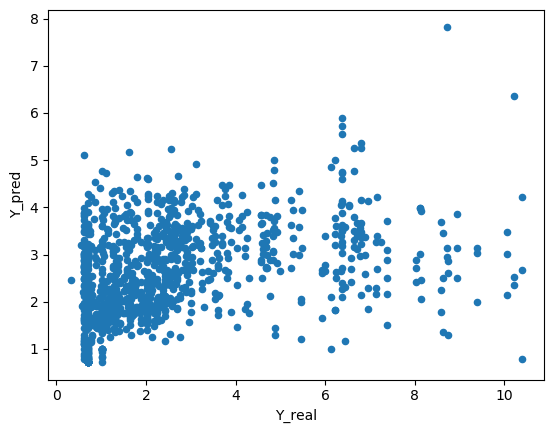

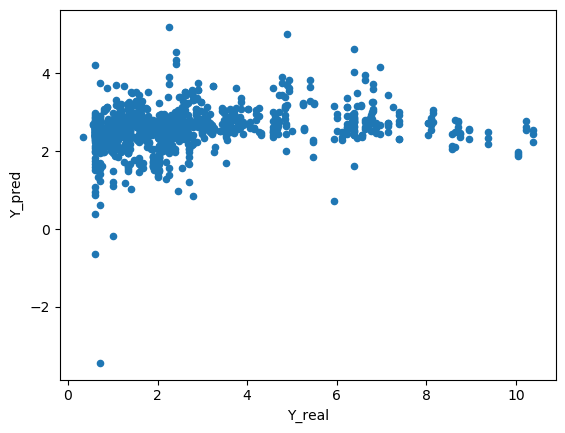

In [13]:
def show_scatter_plot(dict_results, model_name):
    '''
    Función similar a la analiza_resultados, pero esta vez para dibujar las
    predicciones frente a los valores reales-
    '''
    
    reales = []
    predicciones = []
    
    results_ids = dict_results.keys()
    model_results_id = filter(lambda x: x[0]==model_name,results_ids)
    
    # junto en una única lista las predicciones y valores reales que están
    # repartidos por varios folds
    for result_id in model_results_id:
        real,pred = dict_results[result_id]
        reales.extend(real)
        predicciones.extend(pred)
        
    df = pd.DataFrame({"Y_real":reales,"Y_pred":predicciones})
    
    df.plot(kind="scatter",x="Y_real",y="Y_pred")
    
        
show_scatter_plot(resultados,"Random Forest")
show_scatter_plot(resultados,"Regresión Lineal")

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model





## Visualización de predicciones

Creo que podemos usar todo los datos para entrenar el modelo

In [ ]:
y_pred = RandomForestRegressor().fit(X_all,y_all).predict(X_all)

